In [24]:
import scanpy
import hdf5plugin
import pandas
import numpy
import anndata
import scipy
import scvelo
import seaborn

In [5]:
def mtx_to_anndata(path):
    """Generate an anndata object from the STAR aligner output folder.
    Based on https://github.com/alexdobin/STAR/issues/774#issuecomment-850477636."""
    path=path
    # Load Read Counts
    X = scanpy.read_mtx(path+'Velocyto/raw/spliced.mtx')

    # Transpose counts matrix to have Cells as rows and Genes as cols as expected by AnnData objects
    X = X.X.transpose()

    # Load the 3 matrices containing Spliced, Unspliced and Ambigous reads
    mtxU = numpy.loadtxt(path+'Velocyto/raw/unspliced.mtx', skiprows=3, delimiter=' ')
    mtxS = numpy.loadtxt(path+'Velocyto/raw/spliced.mtx', skiprows=3, delimiter=' ')
    mtxA = numpy.loadtxt(path+'Velocyto/raw/ambiguous.mtx', skiprows=3, delimiter=' ')
    mtxG = numpy.loadtxt(path+'Gene/raw/matrix.mtx', skiprows=3, delimiter=' ')

    # Extract sparse matrix shape informations from the third row
    shapeU = numpy.loadtxt(path+'Velocyto/raw/unspliced.mtx', skiprows=2, max_rows = 1 ,delimiter=' ')[0:2].astype(int)
    shapeS = numpy.loadtxt(path+'Velocyto/raw/spliced.mtx', skiprows=2, max_rows = 1 ,delimiter=' ')[0:2].astype(int)
    shapeA = numpy.loadtxt(path+'Velocyto/raw/ambiguous.mtx', skiprows=2, max_rows = 1 ,delimiter=' ')[0:2].astype(int)
    shapeG = numpy.loadtxt(path+'Gene/raw/matrix.mtx', skiprows=2, max_rows = 1 ,delimiter=' ')[0:2].astype(int)

    # Read the sparse matrix with csr_matrix((data, (row_ind, col_ind)), shape=(M, N))
    # Subract -1 to rows and cols index because csr_matrix expects a 0 based index
    # Traspose counts matrix to have Cells as rows and Genes as cols as expected by AnnData objects

    spliced = scipy.sparse.csr_matrix((mtxS[:,2], (mtxS[:,0]-1, mtxS[:,1]-1)), shape = shapeS).transpose()
    unspliced = scipy.sparse.csr_matrix((mtxU[:,2], (mtxU[:,0]-1, mtxU[:,1]-1)), shape = shapeU).transpose()
    ambiguous = scipy.sparse.csr_matrix((mtxA[:,2], (mtxA[:,0]-1, mtxA[:,1]-1)), shape = shapeA).transpose()
    any = scipy.sparse.csr_matrix((mtxG[:,2], (mtxG[:,0]-1, mtxG[:,1]-1)), shape = shapeG).transpose()

    # Load Genes and Cells identifiers
    obs = pandas.read_csv(path+'Velocyto/raw/barcodes.tsv',
                  header = None, index_col = 0)

    # Remove index column name to make it compliant with the anndata format
    obs.index.name = None
    obs["barcode"] = obs.index

    var = pandas.read_csv(path+'Velocyto/raw/features.tsv', sep='\t', usecols=[0, 1], header=None,
                                    names = ["gene_ids", "gene_names"], index_col = 0)
  
    # Build AnnData object to be used with ScanPy and ScVelo
    adata = anndata.AnnData(X = X, obs = obs, var = var,
                                                 layers = {'spliced': spliced, 'unspliced': unspliced,
                                                           'ambiguous': ambiguous, "any": any})
    adata.var_names_make_unique()

    # Subset Cells based on STAR filtering
    selected_barcodes = pandas.read_csv(path+'Gene/filtered/barcodes.tsv', header = None)
    adata = adata[selected_barcodes[0]]

    return adata.copy()

In [10]:
star_path = "RNA Sequencing Data/raw_reads/day2_bfp/"
adata = mtx_to_anndata(star_path)
print(adata)

AnnData object with n_obs × n_vars = 861 × 78334
    obs: 'barcode'
    var: 'gene_names'
    layers: 'spliced', 'unspliced', 'ambiguous', 'any'


In [11]:
# Choose gene names as variable names
adata.var["ensemble_ids"] = adata.var_names
adata.var_names = adata.var["gene_names"].astype(str)
if not adata.var_names.is_unique:
    # Make duplicates unique by adding suffix
    adata.var_names_make_unique()
# Rename gene name
adata.var['gene_symbol'] = adata.var['gene_names']
adata.var = adata.var.drop(columns='gene_names')

In [21]:
print(adata.var_names[adata.var_names.str.startswith("mt")])
print(adata[:, "Hic2"])

Index(['mt-Tf', 'mt-Rnr1', 'mt-Tv', 'mt-Rnr2', 'mt-Tl1', 'mt-Nd1', 'mt-Ti',
       'mt-Tq', 'mt-Tm', 'mt-Nd2', 'mt-Tw', 'mt-Ta', 'mt-Tn', 'mt-Tc', 'mt-Ty',
       'mt-Co1', 'mt-Ts1', 'mt-Td', 'mt-Co2', 'mt-Tk', 'mt-Atp8', 'mt-Atp6',
       'mt-Co3', 'mt-Tg', 'mt-Nd3', 'mt-Tr', 'mt-Nd4l', 'mt-Nd4', 'mt-Th',
       'mt-Ts2', 'mt-Tl2', 'mt-Nd5', 'mt-Nd6', 'mt-Te', 'mt-Cytb', 'mt-Tt',
       'mt-Tp'],
      dtype='object', name='gene_names')
View of AnnData object with n_obs × n_vars = 861 × 1
    obs: 'barcode'
    var: 'ensemble_ids', 'gene_symbol'
    layers: 'spliced', 'unspliced', 'ambiguous', 'any'


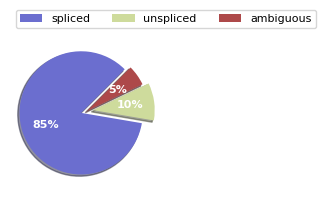

In [ ]:

scvelo.pl.proportions(adata, groupby="sample")

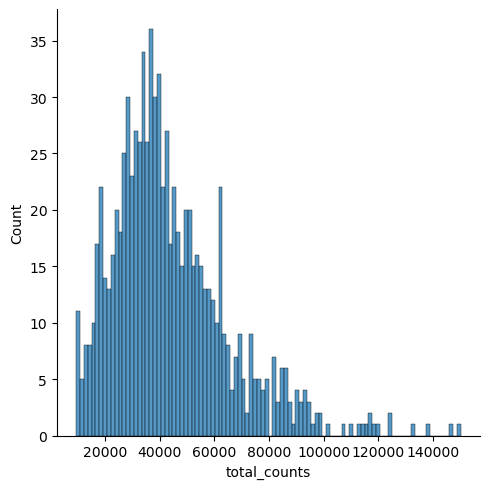

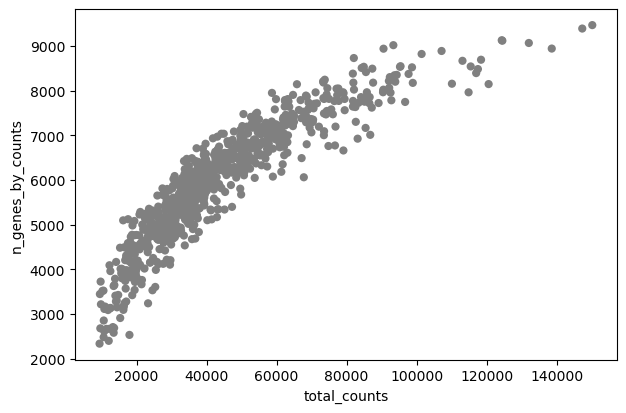

In [25]:
scanpy.pp.calculate_qc_metrics(
    adata, inplace=True, percent_top=[], log1p=False
)
histogram = seaborn.displot(adata.obs["total_counts"], bins=100, kde=False)
scatter = scanpy.pl.scatter(adata, "total_counts", "n_genes_by_counts")

In [64]:
def check_adata(adata):
    print(adata)
    cells = len(adata)
    print(f"Total counts: {adata.layers["any"].sum()/cells:.1f}")
    print(f"Spliced: {adata.layers["spliced"].sum()/cells:.1f}")
    print(f"Unspliced: {adata.layers["unspliced"].sum()/cells:.1f}")
    print(f"Ambiguous: {adata.layers["ambiguous"].sum()/cells:.1f}")
    gene = "Nanog"
    print(f"Gene: {gene}")
    print(f"Total count: {adata[:, gene].layers["any"].sum()}")
    print(f"Spliced: {adata[:, gene].layers["spliced"].sum()}")
    print(f"Unspliced: {adata[:, gene].layers["unspliced"].sum()}")
    print(f"Ambiguous: {adata[:, gene].layers["ambiguous"].sum()}")
    print(f"Nonzero total: {(adata[:, gene].X!=0).sum()}")

In [65]:
check_adata(adata)

AnnData object with n_obs × n_vars = 861 × 78334
    obs: 'barcode', 'n_genes_by_counts', 'total_counts'
    var: 'ensemble_ids', 'gene_symbol', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    layers: 'spliced', 'unspliced', 'ambiguous', 'any'
Total counts: 50995.2
Spliced: 44012.1
Unspliced: 5373.9
Ambiguous: 2832.2
Gene: Nanog
Total count: 294.0
Spliced: 286.0
Unspliced: 54.0
Ambiguous: 2.0
Nonzero total: 113


In [58]:
# Compare with Seurat

seurat_path = "RNA Sequencing Data/seurat_object.h5ad"
adata_seurat = scanpy.read_h5ad(seurat_path)

In [59]:
adata_sample = adata_seurat[adata_seurat.obs["sample"]=="Repro_Day2_BFP"]

In [66]:
print(adata_sample)
cells = len(adata_sample)
print(f"Total counts: {adata_sample.obs["nCount_RNA"].mean()}")
gene = "Nanog"
print(f"Gene: {gene}")
print(f"Total count: {adata_sample[:, gene].X.sum()}")
print(f"Nonzero total: {(adata_sample[:, gene].X!=0).sum()}")

View of AnnData object with n_obs × n_vars = 910 × 20959
    obs: 'barcode', 'exp_day', 'group', 'sample', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'seurat_clusters', 'MEF.identity', 'Pluripotency', 'Proliferation', 'ER.stress', 'Epithelial.identity', 'ECM.rearrangement', 'Apoptosis', 'Senescence', 'Neural.identity', 'Trophoblast.identity', 'X.reactivation', 'XEN', 'Trophoblast.progenitors', 'Spiral.Artery.Trophpblast.Giant.Cells', 'Spongiotrophoblasts', 'Oligodendrocyte.precursor.cells..OPC.', 'Astrocytes', 'Cortical.Neurons', 'RadialGlia.Id3', 'RadialGlia.Gdf10', 'RadialGlia.Neurog2', 'Long.term.MEFs', 'Embryonic.mesenchyme', 'Cxcl12.co.expressed', 'Ifitm1.co.expressed', 'Matn4.co.expressed', '2c', 'keratinization', 'skin.development', 'muscle.structure.development', 'cartilage.development', 'blood.vessel.development', 'skeletal.system.development', 'nervous.system.development', 'neuron.development', 'stem.cell.population.maintenance'
    var: 'vst.mean', 'vst.variance', 'vst.vari

In [61]:
# Compare with Genbank

adata_genbank = scanpy.read_h5ad("RNA Sequencing Data/splice_counts.h5ad")
adata_g_sample = adata_genbank[adata_genbank.obs["sample"]=="Repro_Day2_BFP"]

In [67]:
check_adata(adata_g_sample)

View of AnnData object with n_obs × n_vars = 862 × 40413
    obs: 'barcode', 'sample', 'group', 'day'
    var: 'gene_names'
    layers: 'ambiguous', 'any', 'spliced', 'unspliced'
Total counts: 55969.5
Spliced: 45899.5
Unspliced: 5749.8
Ambiguous: 1216.0
Gene: Nanog
Total count: 295.0
Spliced: 287.0
Unspliced: 55.0
Ambiguous: 2.0
Nonzero total: 113
